In [44]:
# This is the notebook you can use to write your solution.
# Once you run the Docker Compose you should be able to access the notebook at http://localhost:8888/
# and go to the `work` folder to see this notebook.

# You can use the following libraries:
# - psycopg
# - boto3
# - pandas
# If you need to add more libraries, you can do it in the jupyter.Dockerfile file in the root directory.

In [45]:
!pip install minio seaborn pandas psycopg2-binary sqlalchemy matplotlib

In [46]:
import boto3

# MinIO connection details (as per your docker-compose.yml)
MINIO_ENDPOINT = "http://minio:9000"
ACCESS_KEY = "minio_access_key"
SECRET_KEY = "minio_secret_key"

# Initialize MinIO S3 client
s3_client = boto3.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,  # MinIO URL
    aws_access_key_id=ACCESS_KEY,  # MinIO access key
    aws_secret_access_key=SECRET_KEY  # MinIO secret key
)

print(" MinIO client initialized successfully!")


 MinIO client initialized successfully!


In [47]:
# List objects (files) in MinIO buckets
def list_bucket_files(bucket_name):
    try:
        response = s3_client.list_objects_v2(Bucket=bucket_name)
        if 'Contents' in response:
            return [obj['Key'] for obj in response['Contents']]
        else:
            return []
    except Exception as e:
        print(f" Error listing files in bucket {bucket_name}:", str(e))
        return []

# Get files from both buckets
user_files = list_bucket_files("users")
tracker_files = list_bucket_files("trackers")

print("User Files:", user_files[:5])  # Show first 5 files
print("Tracker Files:", tracker_files[:5])  # Show first 5 files


User Files: ['1.csv']
Tracker Files: ['1.jsonl']


In [48]:
import pandas as pd
import json
from io import StringIO, BytesIO

# Function to download a file from MinIO
def download_file(bucket_name, file_key):
    try:
        response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
        return response['Body'].read().decode('utf-8')
    except Exception as e:
        print(f" Error downloading {file_key}:", str(e))
        return None

# Download a sample user CSV file
if user_files:
    sample_user_file = user_files[0]
    user_csv_content = download_file("users", sample_user_file)
    if user_csv_content:
        user_df = pd.read_csv(StringIO(user_csv_content))
        print(" Sample User Data:")
        print(user_df.head())

# Download a sample tracker JSONL file
if tracker_files:
    sample_tracker_file = tracker_files[0]
    tracker_jsonl_content = download_file("trackers", sample_tracker_file)
    if tracker_jsonl_content:
        tracker_lines = [json.loads(line) for line in tracker_jsonl_content.splitlines()]
        print(" Sample Tracker Data:")
        print(tracker_lines[:5])  # Show first 5 events


 Sample User Data:
                                     id     name                email  \
0  e70a276e-e2d7-4b99-b73f-49519a98d5ff     Budi     budi@example.com   
1  ef04d607-78ef-4b39-a7af-457e5a6234ce     Susi     susi@example.com   
2  5b126cdb-b07b-4e8a-b0c7-cf4834a735bb     Joko     joko@example.com   
3  5e9b7699-8e35-4448-a06a-0b8f7050b4d9  Bambang  bambang@example.com   
4  24b2e334-14d0-437e-a7fd-67b21634f239    Ujang    ujang@example.com   

         province  
0      Jawa Barat  
1      Jawa Timur  
2  Sumatera Utara  
3     Jawa Tengah  
4      Jawa Barat  
 Sample Tracker Data:
[{'id': 'cce9edc4-d9d8-4185-ad92-8162df001636', 'user_id': 'e70a276e-e2d7-4b99-b73f-49519a98d5ff', 'event': 'login', 'timestamp': '2025-03-17T00:00:01.123+07:00'}, {'id': 'ca57e60a-5e4d-42ab-be5e-d351896827e9', 'user_id': '24b2e334-14d0-437e-a7fd-67b21634f239', 'event': 'login', 'timestamp': '2025-03-17T00:00:02.234+07:00'}, {'id': '389c65d6-80be-450e-9269-777cd1d69699', 'user_id': '5d6fef4e-99f7-

In [49]:
!pip install psycopg2-binary

In [50]:
import psycopg2

# PostgreSQL connection details
DB_HOST = "postgres"
DB_PORT = "5432"
DB_NAME = "database"
DB_USER = "postgres"
DB_PASSWORD = "postgres"

# Function to connect to PostgreSQL
def get_db_connection():
    try:
        conn = psycopg2.connect(
            host=DB_HOST,
            port=DB_PORT,
            dbname=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD
        )
        conn.autocommit = True
        print("Connected to PostgreSQL!")
        return conn
    except Exception as e:
        print(" Error connecting to PostgreSQL:", str(e))
        return None

# Connect to PostgreSQL
conn = get_db_connection()
cursor = conn.cursor()


Connected to PostgreSQL!


In [51]:
# Create users table
cursor.execute("""
CREATE TABLE IF NOT EXISTS users (
    id UUID PRIMARY KEY,
    name TEXT,
    email TEXT,
    province TEXT
);
""")

# Create trackers table
cursor.execute("""
CREATE TABLE IF NOT EXISTS trackers (
    id UUID PRIMARY KEY,
    user_id UUID REFERENCES users(id),
    event TEXT,
    timestamp TIMESTAMPTZ
);
""")

print("Tables created successfully!")


Tables created successfully!


In [52]:
# Insert users data into PostgreSQL
for _, row in user_df.iterrows():
    cursor.execute("""
    INSERT INTO users (id, name, email, province)
    VALUES (%s, %s, %s, %s)
    ON CONFLICT (id) DO NOTHING;
    """, (row['id'], row['name'], row['email'], row['province']))

print("Users data loaded into PostgreSQL!")


Users data loaded into PostgreSQL!


In [53]:
# Insert tracker data into PostgreSQL
for tracker in tracker_lines:
    cursor.execute("""
    INSERT INTO trackers (id, user_id, event, timestamp)
    VALUES (%s, %s, %s, %s)
    ON CONFLICT (id) DO NOTHING;
    """, (tracker['id'], tracker['user_id'], tracker['event'], tracker['timestamp']))

print("Tracker data loaded into PostgreSQL!")

Tracker data loaded into PostgreSQL!


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style
sns.set(style="darkgrid")

# Connect to PostgreSQL again
conn = get_db_connection()

Connected to PostgreSQL!


/tmp/ipykernel_3687/1509956198.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_daily_users = pd.read_sql(query, conn)


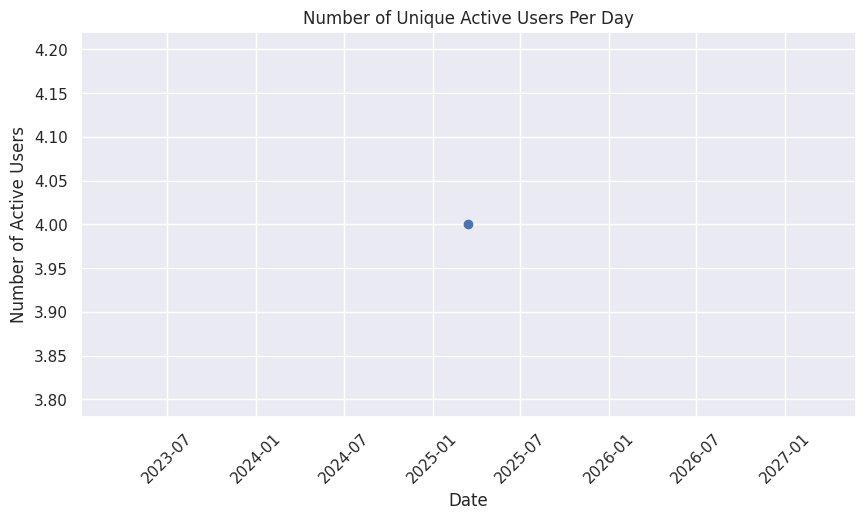

In [55]:
# Query to count unique active users per day
query = """
SELECT DATE(timestamp) as event_date, COUNT(DISTINCT user_id) as unique_users
FROM trackers
GROUP BY event_date
ORDER BY event_date;
"""

df_daily_users = pd.read_sql(query, conn)

# Plot the line chart
plt.figure(figsize=(10, 5))
plt.plot(df_daily_users["event_date"], df_daily_users["unique_users"], marker="o", linestyle="-", color="b")
plt.xlabel("Date")
plt.ylabel("Number of Active Users")
plt.title("Number of Unique Active Users Per Day")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

/tmp/ipykernel_3687/4253426199.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_monthly_users = pd.read_sql(query, conn)


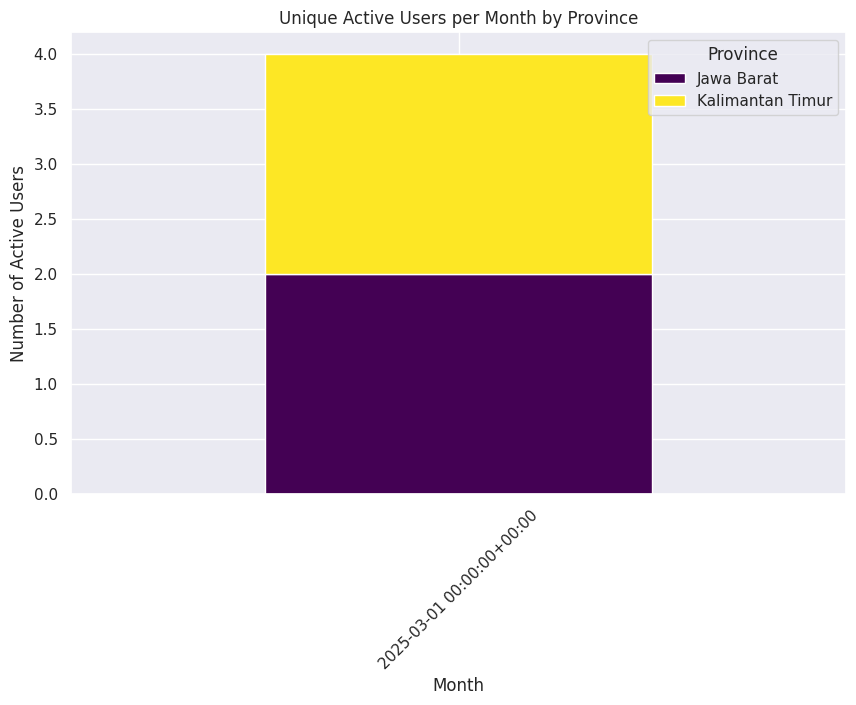

In [56]:
# Query to get unique users per month by province
query = """
SELECT DATE_TRUNC('month', trackers.timestamp) AS event_month, 
       users.province, 
       COUNT(DISTINCT trackers.user_id) AS unique_users
FROM trackers
JOIN users ON trackers.user_id = users.id
GROUP BY event_month, users.province
ORDER BY event_month;
"""

df_monthly_users = pd.read_sql(query, conn)

# Pivot data for plotting
df_pivot = df_monthly_users.pivot(index="event_month", columns="province", values="unique_users")

# Plot the bar chart
df_pivot.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="viridis")
plt.xlabel("Month")
plt.ylabel("Number of Active Users")
plt.title("Unique Active Users per Month by Province")
plt.xticks(rotation=45)
plt.legend(title="Province")
plt.show()


/tmp/ipykernel_3687/2848143825.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_weekly_events = pd.read_sql(query, conn)


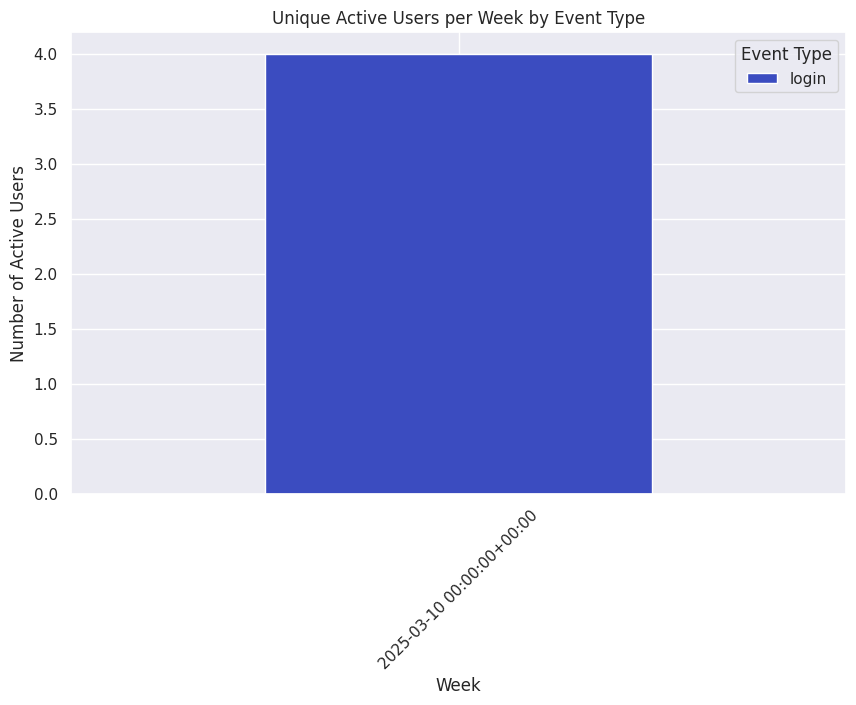

In [57]:
# Query to count unique users per week by event type
query = """
SELECT DATE_TRUNC('week', timestamp) AS event_week, 
       event, 
       COUNT(DISTINCT user_id) AS unique_users
FROM trackers
GROUP BY event_week, event
ORDER BY event_week;
"""

df_weekly_events = pd.read_sql(query, conn)

# Pivot data for plotting
df_pivot = df_weekly_events.pivot(index="event_week", columns="event", values="unique_users")

# Plot the bar chart
df_pivot.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm")
plt.xlabel("Week")
plt.ylabel("Number of Active Users")
plt.title("Unique Active Users per Week by Event Type")
plt.xticks(rotation=45)
plt.legend(title="Event Type")
plt.show()